# <span style='color:Black'> **Verifiable Lagrange Interpolation**  </span> 

Lagrange interpolation is a mathematical technique used to approximate a function that passes through a given set of points. It takes an input set of data points and computes a polynomial that passes through all of them. 

Given a set of $n+1$ data points (or interpolation nodes) $X_0, X_1, ..., X_n$ with corresponding function values $Y_0, Y_1, ..., Y_n$, Lagrange interpolation seeks to find a polynomial of degree at most $n$ that passes through all these points.

Below, we provide a brief review of the implementation of a Lagrange interpolation in Python, which we will then convert to Cairo to transform it into a verifiable ZKML (Lagrange interpolation), using the Orion library. 

### <span style='color:Black'> **Used DataSet**  </span>

In this tutorial, we will interpolate the Runge function, that we will define $f$ and uses the Chebyshev node as interpolation nodes.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Runge function
def f(x):
    return 1 / (x**2 + 1)

# Chebyshev nodes
X = np.array( [5*math.cos(k*math.pi/10) for k in range(0,11)] )

Y = f(X)

In [3]:
print(X)
print(Y)

[ 5.00000000e+00  4.75528258e+00  4.04508497e+00  2.93892626e+00
  1.54508497e+00  3.06161700e-16 -1.54508497e+00 -2.93892626e+00
 -4.04508497e+00 -4.75528258e+00 -5.00000000e+00]
[0.03846154 0.04235007 0.05759469 0.10376364 0.29522147 1.
 0.29522147 0.10376364 0.05759469 0.04235007 0.03846154]


Now we will implement Lagrange interpolation function in python.

Given a set of $n+1$ data points $X_0, X_1, ..., X_n$ with corresponding function values $Y_0, Y_1, ..., Y_n$, the Lagrange interpolating polynomial is

$$
    L(x) = \sum_{i=0}^n Y_i \phi_i(x), 
$$

where $\phi_i(x)$ is the $i$-th Lagrange polynomial defined by 
$$
    \phi_i(x) = \frac{(x - X_0)\ldots (x - X_{i-1})(x - X_{i+1})\ldots(x - X_n)}{(X_i - X_0)\ldots (X_i - X_{i-1})(X_i - X_{i+1})\ldots(X_i - X_n)}

$$

In [4]:
              
def lagrange(x,X,Y):
 
  n = min(len(X),len(Y))
  m = len(x)  
  yh = np.zeros(m)
  phi = np.zeros(n)  

  for j in range(m):
    yh[j] = 0
    for i in range(n):
      phi[i] = 1.0
      for k in range(n):
        if i != k:
          phi[i] = phi[i]*(x[j]-X[k])/(X[i]-X[k])
      yh[j] = yh[j] + Y[i] * phi[i]
      
  return yh

We will now visualize the computed Lagrange interpolation and compare it to the function we interpolated, the Runge function.


In [5]:
x = np.linspace(-5,5,num=100)
fx = f(x)
y = lagrange(x,X,Y)

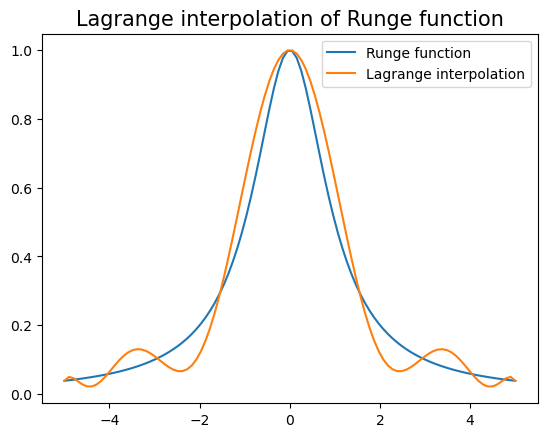

In [6]:
fig, ax = plt.subplots()
ax.set_title('Lagrange interpolation of Runge function', fontsize = 15)
ax.plot(x,fx,label='Runge function')
ax.plot(x,y,label='Lagrange interpolation')
plt.legend()

## <span style='color:Black'> **Convert your model to Cairo**  </span>

### <span style='color:Black'> **Generating Cairo files**  </span>

Now let's generate Cairo files for each tensor in the object.

In [7]:
def decimal_to_fp16x16(num):

    whole_num = int(num)
    fractional_part = int((num - whole_num) * 65536)
    fp_number = (whole_num << 16) + fractional_part
    return fp_number

In [8]:
import os

In [9]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
new_directory_path = os.path.join(parent_directory, "src/generated")

In [10]:
os.makedirs('src/generated', exist_ok=True) 

In [11]:
tensor_name = ["X","Y","x","y"]

def generate_cairo_files(data, name):

    with open(os.path.join('src', 'generated', f"{name}.cairo"), "w") as f:
        f.write(
            "use array::{ArrayTrait, SpanTrait};\n" +
            "use orion::operators::tensor::{core::{Tensor, TensorTrait}};\n" +
            "use orion::operators::tensor::FP16x16Tensor;\n" +
            "use orion::numbers::fixed_point::implementations::fp16x16::core::{FP16x16, FixedTrait};\n" +
            "\n" + f"fn {name}() -> Tensor<FP16x16>" + "{\n\n" + 
            "let mut shape = ArrayTrait::new();\n"
        )
        for dim in data.shape:
            f.write(f"shape.append({dim});\n")
    
        f.write("let mut data = ArrayTrait::new();\n")
        for val in np.nditer(data.flatten()):
            f.write(f"data.append(FixedTrait::new({abs(int(decimal_to_fp16x16(val)))}, {str(val < 0).lower()}));\n")
        f.write(
            "let tensor = TensorTrait::<FP16x16>::new(shape.span(), data.span());\n" +
            "return tensor;\n}"
        )

with open(f"src/generated.cairo", "w") as f:
    for n in tensor_name:
        f.write(f"mod {n};\n")

generate_cairo_files(X, "X")
generate_cairo_files(Y, "Y")

generate_cairo_files(x, "x")
generate_cairo_files(y, "y")


<span style='color:Black'> **Convert some hyperparameters to FP16x16**  </span>

In [12]:
tol=1e-2
max_iter=500

In [13]:
print(decimal_to_fp16x16(tol))
print(decimal_to_fp16x16(max_iter))

655
32768000


<span style='color:Black'> **Get an estimate for the first two values of eigenvalus and first eigenvector in FP16x16**  </span>